# Collaborative Recommendation System and Hybrid Recommendation System

## AML 3204 1 Social Media Analytics

### Team TAJU


In [226]:
#Importing necessary libraries for text data processing
import pandas as pd
import numpy as np
import tweepy as tw
import re
import nltk
from nltk.corpus import stopwords

### Movie Lens Dataset

This dataset consist of following items.

u.data - The full 'u' data set, 100000 ratings by 943 users on 1682 items. Each user has rated at least 20 movies.

u.item - Information about the items (movies).

u.genre - A list of the genres

In [227]:
# Import u.item file to dataframe df_data
df_item = pd.read_csv('u.item', sep='|', header=None,  encoding='latin-1')
df_item.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [230]:
# Import u.data file to dataframe df
df_data = pd.read_csv('u.data', sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
df_data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


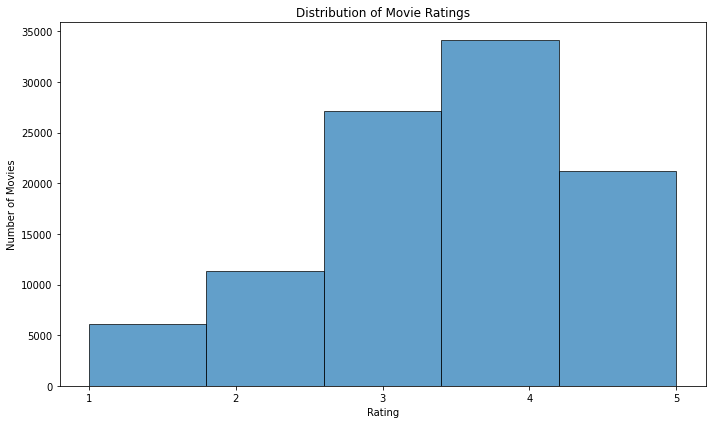

In [231]:
#the distribution of movies based on ratings using the provided dataset
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(df_data['rating'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.xticks(range(1, 6))
plt.tight_layout()
plt.show()


In [232]:
# Import u.genre file to dataframe df
df_genre = pd.read_csv('u.genre', sep='|', names=["genre", "id"])
df_genre.head()

,genre,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


Now we will replace the headings for genre in item data from the genre list in genre data and also for other columns

In [233]:
genre = list(df_genre["genre"])
column_names = ['item_id', 'movie_title','release_date', 'video_release_date',
         'IMDb_URL']
column_names.extend(genre)
df_item.columns = column_names
df_item.head()


,item_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [234]:
# Define a function to clean movie titles
def clean_movie_title(title):
    title = title.strip()  # Remove leading and trailing spaces
    if title.endswith(", The"):
        title = "The " + title[:-5]
    elif title.endswith(", An"):
        title = "An " + title[:-4]
    elif title.endswith(", A"):
        title = "A " + title[:-3]
    title = title.replace(",", "")  # Remove commas
    return title

# Apply the clean_movie_title function to the 'movie_title' column
df_item['movie_title'] = df_item['movie_title'].apply(clean_movie_title)

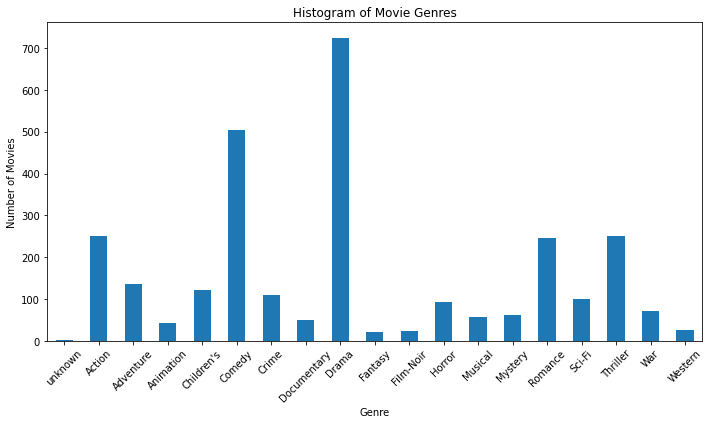

In [235]:
# histogram based on genre. 
import matplotlib.pyplot as plt

# Remove non-genre columns
genre_columns = df_item.columns[5:]

# Sum the occurrences of each genre
genre_counts = df_item[genre_columns].sum()

# Plotting
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Histogram of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1. Collaborative Filter Recommendation System

Using this MovieLens dataset, now we will create a collaborative filtering recommendation system. In order todo so, we will use the concept of Matrix Factorization. Given a matrix of m*n, the rows represent m users and n column represent n items. An entry Rij will represent the 'i'th users rating on 'j'th item.

In [236]:
#Using pandas pivot method, we will represent items and rows. Rows will represent users and columns will represent items.
rating_matrix = df_data.pivot(index = 'user_id', columns ='item_id', values = 'rating')
rating_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
#The NaN value means that the user has not rated that particular movie. 
#We will fill them with zeroes
proc_rating_matrix = rating_matrix.fillna(0)
proc_rating_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To find out the average rating that each user has given to all the items, we will simply take the row wise mean

In [238]:
#First we take the numpy representation of the values
numpy_rm = proc_rating_matrix.values
numpy_rm

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [239]:
#Now we take the row wise mean
ratings_mean = np.mean(numpy_rm, axis = 1)
ratings_mean

array([0.58382878, 0.13674197, 0.08977408, 0.06183115, 0.29904875,
       0.45600476, 0.95005945, 0.13317479, 0.05588585, 0.46016647,
       0.37277051, 0.13317479, 1.17122473, 0.23840666, 0.17776457,
       0.36028537, 0.05053508, 0.6391201 , 0.04221165, 0.08858502,
       0.28418549, 0.25505351, 0.32639715, 0.17479191, 0.18787158,
       0.18727705, 0.04815696, 0.17479191, 0.07372176, 0.09631391,
       0.08382878, 0.08085612, 0.0529132 , 0.04815696, 0.04458977,
       0.0451843 , 0.12366231, 0.26753864, 0.04934602, 0.06004756,
       0.11652794, 0.40546968, 0.48751486, 0.32758621, 0.10285375,
       0.06599287, 0.05410226, 0.14863258, 0.343044  , 0.05053508,
       0.04875149, 0.14209275, 0.06361474, 0.14268728, 0.04102259,
       0.40487515, 0.22057075, 0.35136742, 0.89357907, 0.50535077,
       0.03686088, 0.45541023, 0.17241379, 0.42627824, 0.18727705,
       0.078478  , 0.06718193, 0.06123662, 0.14863258, 0.26991677,
       0.08561237, 0.31093936, 0.14625446, 0.08442331, 0.15398

### Normalization ratings

We do this so we can get either positive or negative values as rating and we can make clusters of the users with similar rating to similar items. And later, we can use these clusters to recommend the items to the users.

In [240]:
#Now we will normalize the ratings of the user by substarcting all the raings with mean rating of the corresponding user.
norm_rating_matrix = numpy_rm - ratings_mean.reshape(-1,1)
norm_rating_matrix.shape

(943, 1682)

### Singlular Value Decomposition 

SVD is a matrix factorization technique that decomposes a matrix into three matrices: U, Σ, and Vᵀ.

Given a matrix A of size m × n, the SVD factorizes it as follows:
A = UΣVᵀ

where:

-- "U" (Left Singular Matrix):

Dimensions: (num_users, num_users) or (num_users, k) after truncation.
Represents: This matrix contains the left singular vectors of the original user-item interaction matrix. Each row of "U" represents a user's latent feature vector. The latent features captured in "U" encode user preferences and represent how strongly a user is associated with each latent feature. When "U" is truncated to keep only the top "k" latent vectors (after SVD), it forms the basis for approximating the user-item interaction matrix with lower-dimensional latent space.


-- "sigma" (Singular Values):

Dimensions: (k, k) after truncation, where "k" is the number of latent factors chosen.
Represents: "sigma" is a diagonal matrix containing the singular values of the original user-item interaction matrix. The singular values represent the strength or importance of each latent feature. These values are arranged in descending order, meaning the first singular value corresponds to the most important latent feature, the second singular value corresponds to the second-most important latent feature, and so on. By keeping only the top "k" singular values (after SVD truncation), we retain the most significant latent features and form the basis for approximation.

-- "Vt" (Right Singular Matrix):

Dimensions: (k, num_items) after truncation.
Represents: This matrix contains the right singular vectors of the original user-item interaction matrix. Each row of "Vt" represents an item's latent feature vector. The latent features captured in "Vt" encode item characteristics and represent how strongly an item is associated with each latent feature. When "Vt" is truncated to keep only the top "k" latent vectors (after SVD), it also forms the basis for approximating the user-item interaction matrix with lower-dimensional latent space.

These singular values represent the importance of each column/row in the original matrix.

In a simple way, Think of a large spreadsheet where each row represents a person, each column represents a type of movie, and the numbers in the spreadsheet represent how much each person likes each type of movie. SVD is like breaking down this spreadsheet into three smaller spreadsheets that help us understand the data better.
The first smaller spreadsheet tells us about the types of movie genres (like action, comedy, etc.) and how much each person likes those genres. The second spreadsheet tells us about how strong each genre is in influencing people's preferences. The third spreadsheet tells us how much each person likes each genre of movie.

We use scipy to perform SVD. Here Σ is represented with S and result R = U * S * Vt

Steps involved are:

1. Calculate the Covariance Matrix

2. Compute Eigenvectors and Eigenvalues

3. Sort and Select Top Singular Values

4. Create Matrices U, Σ, and Vᵀ

5. Reconstruction of Approximated Matrix

Here, while calling the SVD function in scipy, we need to pass the number of latent features. This number should be an optimum value and we need to find that. Let's call it k and now we find this 'k' value.

We will find this 'k' using using RMSE. Which ever k value gives the lowest RMSE, its the best k value.

### Hyperparameter tuning

20 0.644834678959412
30 0.620484546802225
40 0.5992076028777387
50 0.5796462668260163


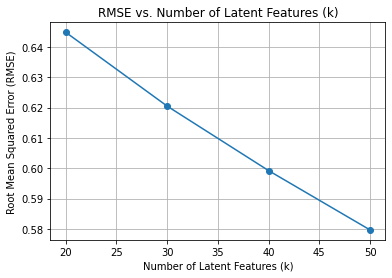

The best value of k is: 50


In [241]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

def cal_matrix_rmse(predicted_ratings, actual_ratings):
    mask = ~np.isnan(actual_ratings)
    mse = mean_squared_error(predicted_ratings[mask], actual_ratings[mask])
    return np.sqrt(mse)

def find_best_k(data_matrix, krange=[50]):
    k_stat = []
    user_ratings_mean = np.nanmean(data_matrix, axis=1)
    RM_demeaned = data_matrix - user_ratings_mean.reshape(-1, 1)

    for k in krange:
        U_k, sigma_k, Vt_k = svds(RM_demeaned, k=k)
        sigma_k = np.diag(sigma_k)
        m1 = np.dot(U_k, sigma_k)
        all_user_predicted_ratings = np.dot(m1, Vt_k) + user_ratings_mean.reshape(-1, 1)

        rmse = cal_matrix_rmse(all_user_predicted_ratings, data_matrix)
        if k%10 == 0:
            print(k, rmse)
        k_stat.append([k, rmse])
        del U_k, sigma_k, Vt_k

    return k_stat

K_range = [20, 30, 40, 50]
best_k_stat = np.array(find_best_k(numpy_rm, K_range))

# Extract k values and RMSE values from k_stat
k_values = best_k_stat[:, 0]
rmse_values = best_k_stat[:, 1]

# Plot the RMSE values for different k values
plt.plot(k_values, rmse_values, marker='o')
plt.xlabel('Number of Latent Features (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs. Number of Latent Features (k)')
plt.grid(True)
plt.show()

# Find the best k with the lowest RMSE
best_k = int(k_values[np.argmin(rmse_values)])
print(f"The best value of k is: {best_k}")


As you can see, RMSE value decreases as number of latent vectors increases. We will select k value as 50 to reduce computational complexity.

In [242]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

# 500 latent factors
U, sigma, Vt = svds(norm_rating_matrix, k = 50)
#Sigma is a r x r diagonal matrix
sigma = np.diag(sigma)

print("Shape of user-rating-item matrix rep by m X n: ", norm_rating_matrix.shape)

print("Shape of users and latent factors relationship matrix (U) represented by m X r: ", U.shape)

print("Shape of matrix that describes similarity between items and latent factors (Vt) represented by r X n : ", Vt.shape)

print("Shape of  the strength of each latent factor (Sigma): ", sigma.shape)

Shape of user-rating-item matrix rep by m X n:  (943, 1682)
Shape of users and latent factors relationship matrix (U) represented by m X r:  (943, 50)
Shape of matrix that describes similarity between items and latent factors (Vt) represented by r X n :  (50, 1682)
Shape of  the strength of each latent factor (Sigma):  (50, 50)


The SVD decreases the dimension of the utility matrix A by extracting its latent factors. It maps each user and each item into a r-dimensional latent space. This mapping facilitates a clear representation of relationships between users and items. To determine the users rating on each movie item, we compute U.Sigma.Vt.

In [243]:
# We add ratings_mean.reshape(-1,1) to the ratings_mean.reshape(-1,1) 
#in prediction step to obtain a more accurate and personalised prediction of user_item interactions
#This will accounts for user biases and missing values. 
#Basically we are reverting the normalisarion step for predicting,
#i.e bringing back the original scale
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + ratings_mean.reshape(-1,1) #U.Sigma.Vt.+normalization
# numpy array to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = proc_rating_matrix.columns)
preds_df.head(25)

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,6.488436,2.959503,1.634987,3.024467,1.656526,1.659506,3.630469,0.240669,1.791518,3.347816,...,0.011976,-0.092017,-0.074553,-0.060985,0.009427,-0.035641,-0.039227,-0.037434,-0.025552,0.023513
1,2.347262,0.129689,-0.098917,0.328828,0.159517,0.481361,0.213002,0.097908,1.892100,0.671000,...,0.003943,-0.026939,-0.035460,-0.029883,-0.027153,-0.015244,-0.008277,-0.011760,0.011639,-0.046924
2,0.291905,-0.263830,-0.151454,-0.179289,0.013462,-0.088309,-0.057624,0.568764,-0.018506,0.280742,...,-0.028964,-0.031622,0.045513,0.026089,-0.021705,0.002282,0.032363,0.017322,-0.006644,-0.009480
3,0.366410,-0.443535,0.041151,-0.007616,0.055373,-0.080352,0.299015,-0.010882,-0.160888,-0.118834,...,0.020069,0.015981,-0.000182,0.005593,0.026634,0.023562,0.036405,0.029984,0.015612,-0.008713
4,4.263488,1.937122,0.052529,1.049350,0.652765,0.002836,1.730461,0.870584,0.341027,0.569055,...,0.019973,-0.053521,-0.017242,-0.007137,-0.038987,0.010338,0.004869,0.007603,-0.020575,0.003330
5,4.148847,0.632284,-0.162395,1.257272,0.039363,0.437853,1.209609,4.253422,3.141518,0.594382,...,-0.008007,0.051870,-0.011058,-0.011120,0.056687,-0.010919,-0.010268,-0.010594,-0.047157,-0.070847
6,0.801353,0.483915,-0.812745,3.699021,1.182636,0.185400,5.643688,4.694295,5.390618,2.579990,...,0.066109,0.049142,0.009361,0.016382,0.031036,0.029074,0.026375,0.027725,0.078739,-0.018583
7,0.809382,1.171313,0.145453,1.705231,-0.116285,-0.113923,1.398678,-0.061472,-0.017668,0.323107,...,-0.018561,-0.015051,0.020218,0.014562,0.019307,0.004304,0.006416,0.005360,0.017669,-0.012525
8,0.534477,0.067146,0.185693,-0.266624,0.147181,0.284919,0.766372,-0.056353,0.917445,-0.074863,...,0.008527,-0.009335,0.014435,0.011283,-0.006416,0.005054,0.005203,0.005129,0.003628,0.009089
9,0.092534,-0.157302,-0.113811,3.355354,0.918156,0.108448,3.412482,2.368166,3.652021,0.603316,...,-0.042567,0.039274,0.123128,0.082222,0.074133,-0.000930,-0.003614,-0.002272,0.001314,-0.044856


User ratings varies between 1-5. So we normalize ratings to this range. All ratings above 5 will be rated as 5 and all below will be rated as 1.

In [244]:
def cap_rating(input_matrix):
    for i in range(len(input_matrix)):
        for j in range(len(input_matrix[i])):
            if input_matrix[i][j]<1:
                input_matrix[i][j]=1
            if input_matrix[i][j]>5:
                input_matrix[i][j]=5
            input_matrix[i][j]=int(input_matrix[i][j])
    return input_matrix

all_user_predicted_ratings_capped = cap_rating(all_user_predicted_ratings)
all_user_predicted_ratings_capped

array([[5., 2., 1., ..., 1., 1., 1.],
       [2., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [3., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 2., 1., ..., 1., 1., 1.]])

### Classification report for SVD based Collaborative Filtering

In [245]:
predict_rated, original_rated =[],[]
for i in range(len(all_user_predicted_ratings_capped)):
        for j in range(len(all_user_predicted_ratings_capped[i])):
            if numpy_rm[i][j]>0:
                original_rated.append(numpy_rm[i][j])                
                predict_rated.append(all_user_predicted_ratings_capped[i][j])

In [246]:
original_rated

[5.0,
 3.0,
 4.0,
 3.0,
 3.0,
 5.0,
 4.0,
 1.0,
 5.0,
 3.0,
 2.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 3.0,
 4.0,
 5.0,
 4.0,
 1.0,
 4.0,
 4.0,
 3.0,
 4.0,
 3.0,
 2.0,
 4.0,
 1.0,
 3.0,
 3.0,
 5.0,
 4.0,
 2.0,
 1.0,
 2.0,
 2.0,
 3.0,
 4.0,
 3.0,
 2.0,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 4.0,
 5.0,
 3.0,
 5.0,
 4.0,
 4.0,
 3.0,
 3.0,
 5.0,
 4.0,
 5.0,
 4.0,
 5.0,
 5.0,
 4.0,
 3.0,
 2.0,
 5.0,
 4.0,
 4.0,
 3.0,
 4.0,
 3.0,
 3.0,
 3.0,
 4.0,
 3.0,
 1.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 5.0,
 5.0,
 3.0,
 4.0,
 3.0,
 5.0,
 5.0,
 4.0,
 5.0,
 4.0,
 5.0,
 3.0,
 5.0,
 2.0,
 4.0,
 5.0,
 3.0,
 4.0,
 3.0,
 5.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 4.0,
 4.0,
 5.0,
 5.0,
 1.0,
 5.0,
 1.0,
 5.0,
 5.0,
 5.0,
 3.0,
 3.0,
 3.0,
 5.0,
 1.0,
 4.0,
 3.0,
 4.0,
 5.0,
 3.0,
 2.0,
 5.0,
 4.0,
 5.0,
 3.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 5.0,
 1.0,
 3.0,
 1.0,
 3.0,
 2.0,
 1.0,
 4.0,
 2.0,
 4.0,
 3.0,
 2.0,
 2.0,
 5.0,
 4.0,
 5.0,
 3.0,
 5.0,
 2.0,
 4.0,
 4.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 5.0,
 5.0,
 2.0

In [247]:
predict_rated

[5.0,
 2.0,
 1.0,
 3.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 3.0,
 2.0,
 5.0,
 4.0,
 3.0,
 4.0,
 2.0,
 2.0,
 1.0,
 3.0,
 2.0,
 1.0,
 2.0,
 2.0,
 3.0,
 4.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 3.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 3.0,
 1.0,
 2.0,
 3.0,
 1.0,
 3.0,
 1.0,
 2.0,
 5.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.0,
 4.0,
 1.0,
 2.0,
 4.0,
 4.0,
 3.0,
 1.0,
 1.0,
 4.0,
 3.0,
 1.0,
 1.0,
 3.0,
 4.0,
 3.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 4.0,
 3.0,
 2.0,
 1.0,
 1.0,
 1.0,
 4.0,
 3.0,
 5.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 4.0,
 2.0,
 5.0,
 1.0,
 5.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 4.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 2.0,
 1.0,
 4.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 3.0,
 5.0,
 2.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 4.0,
 3.0,
 1.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0

In [248]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report

def get_metrics(y_test, y_pred):
    
    mae_value = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse) #mse**(0.5) 

    print('Precision of the selected model: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Recall of the selected model: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('F1-score of the selected model: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('\nRMSE loss of the selected model: ', round(rmse_value, 3))
    print('\nMAE loss of the selected model: ', round(mae_value, 3))
    
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']))
get_metrics(original_rated,predict_rated)

Precision of the selected model: 0.16
Recall of the selected model: 0.16
F1-score of the selected model: 0.16


RMSE loss of the selected model:  2.019

MAE loss of the selected model:  1.69

Classification Report

              precision    recall  f1-score   support

    Rating 1       0.11      0.92      0.20      6110
    Rating 2       0.08      0.16      0.10     11370
    Rating 3       0.19      0.11      0.14     27145
    Rating 4       0.40      0.09      0.14     34174
    Rating 5       0.75      0.11      0.19     21201

    accuracy                           0.16    100000
   macro avg       0.30      0.28      0.15    100000
weighted avg       0.36      0.16      0.15    100000



### Recommending movies using our collaborative filter

In [249]:
# Define a function to clean movie titles
def clean_movie_title(title):
    title = title.strip()  # Remove leading and trailing spaces
    if title.endswith(", The"):
        title = "The " + title[:-5]
    elif title.endswith(", An"):
        title = "An " + title[:-4]
    elif title.endswith(", A"):
        title = "A " + title[:-3]
    title = title.replace(",", "")  # Remove commas
    return title

# Apply the clean_movie_title function to the 'movie_title' column
df_item['movie_title'] = df_item['movie_title'].apply(clean_movie_title)

In [250]:
# Keeping only movieID and title for convenience
movies_df= df_item[['item_id','movie_title']]
movies_df.head(10)

,item_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


In [251]:
# Function to generate list of movies
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'item_id', right_on = 'item_id').
                     sort_values(['rating'], ascending=False)
                 )

    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending the highest {num_recommendations} predicted ratings movies not already rated.')
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['item_id'].isin(user_full['item_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'item_id',
               right_on = 'item_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

#### Lets find the top 10 and 20 recommendations for the user 877

In [252]:
#Top 10 recommendations
uid=877
number_of_recommendation= 10
already_rated, predictions = recommend_movies(preds_df, uid, movies_df, df_data, number_of_recommendation)


User 877 has already rated 81 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [253]:
# list of movies rated by User
already_rated.head(10)

,user_id,item_id,rating,timestamp,movie_title
47,877,164,5,882678547,Abyss The (1989)
52,877,56,5,882678483,Pulp Fiction (1994)
68,877,61,5,882677244,Three Colors: White (1994)
69,877,371,5,882677935,Bridges of Madison County The (1995)
63,877,531,5,882677128,Shine (1996)
29,877,70,5,882677012,Four Weddings and a Funeral (1994)
10,877,59,5,882677012,Three Colors: Red (1994)
9,877,60,5,882677183,Three Colors: Blue (1993)
67,877,14,5,882677048,Postino Il (1994)
59,877,98,5,882678427,Silence of the Lambs The (1991)


In [60]:
# list of recommended movies
predictions

,item_id,movie_title
174,198,Nikita (La Femme Nikita) (1990)
57,66,While You Were Sleeping (1995)
83,97,Dances with Wolves (1990)
186,213,"Room with a View, A (1986)"
0,1,Toy Story (1995)
1066,1147,My Family (1995)
1074,1155,"Rendezvous in Paris (Rendez-vous de Paris, Les..."
1073,1154,Alphaville (1965)
1072,1153,Backbeat (1993)
1071,1152,In Love and War (1996)


In [62]:
#Top 20 Recommendations
uid=877
number_of_recommendation= 20
already_rated, predictions = recommend_movies(preds_df, uid, movies_df, df_data, number_of_recommendation)

User 877 has already rated 81 movies.
Recommending the highest 20 predicted ratings movies not already rated.


In [63]:
# list of movies rated by User
already_rated.head(20)

,user_id,item_id,rating,timestamp,movie_title
47,877,164,5,882678547,"Abyss, The (1989)"
52,877,56,5,882678483,Pulp Fiction (1994)
68,877,61,5,882677244,Three Colors: White (1994)
69,877,371,5,882677935,"Bridges of Madison County, The (1995)"
63,877,531,5,882677128,Shine (1996)
29,877,70,5,882677012,Four Weddings and a Funeral (1994)
10,877,59,5,882677012,Three Colors: Red (1994)
9,877,60,5,882677183,Three Colors: Blue (1993)
67,877,14,5,882677048,"Postino, Il (1994)"
59,877,98,5,882678427,"Silence of the Lambs, The (1991)"


In [64]:
# list of recommended movies
predictions

,item_id,movie_title
174,198,Nikita (La Femme Nikita) (1990)
57,66,While You Were Sleeping (1995)
83,97,Dances with Wolves (1990)
186,213,"Room with a View, A (1986)"
0,1,Toy Story (1995)
1066,1147,My Family (1995)
1074,1155,"Rendezvous in Paris (Rendez-vous de Paris, Les..."
1073,1154,Alphaville (1965)
1072,1153,Backbeat (1993)
1071,1152,In Love and War (1996)


In [65]:
# Calculate metric error for Top 10 items
top_10 =pd.DataFrame( columns=["user_id","rmse","mae","precision","recall","f1"])

from sklearn.metrics import mean_squared_error, mean_absolute_error


for i in range(len(all_user_predicted_ratings_capped)): # for each user
    or_rated,pr_rated=[],[]
    index_loc_pr =all_user_predicted_ratings_capped[i].argsort()[-10:][::-1] 

    for item in index_loc_pr: # taking each index of recommended 
        if numpy_rm[i][item]>0:    # only item rated by original user        
            or_rated.append(int(numpy_rm[i][item])) # adding original rating to list
            pr_rated.append(int(all_user_predicted_ratings_capped[i][item])) # adding predicted rating 

    if len(or_rated)==0:
        rmse=0
        mae=0
        recall=0
        precision=0
        f1=0
    else:
        mae = mean_absolute_error(or_rated, pr_rated) 
        mse = mean_squared_error(or_rated, pr_rated)
        rmse = np.sqrt(mse)
        
        total_true = 0  
        marked_true = 0
        for j in range(len(numpy_rm[i])): # for index of every movie
            if numpy_rm[i][j]>0: # if rated by user
                total_true+=1 # total positive
                if j in index_loc_pr: # if index value is in recommended list
                    marked_true+=1 # true positive from model
        recall=marked_true/10
        if total_true>0:
            precision=marked_true/total_true
        else:
            precision=0
        if precision+recall==0:
            f1=0
        else:
            f1=2*(recall * precision) / (recall + precision)
        
    top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\2749375618.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\Ap

In [66]:
# Calculate metric error for Top 20 items
top_20 =pd.DataFrame( columns=["user_id","rmse","mae","precision","recall","f1"])

from sklearn.metrics import mean_squared_error, mean_absolute_error


for i in range(len(all_user_predicted_ratings_capped)):
    or_rated,pr_rated=[],[]
    index_loc_pr =all_user_predicted_ratings_capped[i].argsort()[-20:][::-1]
    for item in index_loc_pr:
        if numpy_rm[i][item]>0:    # only item rated by original user        
            or_rated.append(int(numpy_rm[i][item]))
            pr_rated.append(int(all_user_predicted_ratings_capped[i][item]))

    if len(or_rated)==0:
        rmse=0
        mae=0
        recall=0
        precision=0
        f1=0
    else:
        mae = mean_absolute_error(or_rated, pr_rated)
        mse = mean_squared_error(or_rated, pr_rated)
        rmse = np.sqrt(mse)
        
        total_true = 0
        marked_true = 0
        for j in range(len(numpy_rm[i])):
            if numpy_rm[i][j]>0:
                total_true+=1
                if j in index_loc_pr:
                    marked_true+=1
        recall=marked_true/20
        if total_true>0:
            precision=marked_true/total_true
        else:
            precision=0
        if precision+recall==0:
            f1=0
        else:
            f1=2*(recall * precision) / (recall + precision)
        
    top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2476\484264604.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_20 = top_20.append({'user_id':i+1,'rmse':rmse,'mae':mae,'precision':precision,'recall':recall,'f1':f1 },ignore_index=True)
C:\Users\ASUS\AppDa

In [67]:
top_10

,user_id,rmse,mae,precision,recall,f1
0,1.0,0.316228,0.1,0.036765,1.0,0.070922
1,2.0,1.183216,1.0,0.16129,1.0,0.277778
2,3.0,1.581139,1.1,0.185185,1.0,0.3125
3,4.0,2.160247,2.0,0.25,0.6,0.352941
4,5.0,1.095445,0.8,0.057143,1.0,0.108108
...,...,...,...,...,...,...
938,939.0,1.825742,1.777778,0.183673,0.9,0.305085
939,940.0,1.048809,0.9,0.093458,1.0,0.17094
940,941.0,2.20794,2.125,0.363636,0.8,0.5
941,942.0,1.699673,1.555556,0.113924,0.9,0.202247


In [68]:
# Printing metrics top 10
print('RMSE mean: {}'.format(round(top_10.rmse.mean(), 3)))
print('MAE mean: {}'.format(round(top_10.mae.mean(), 3)))
print('Recall mean: {}'.format(round(top_10.recall.mean(), 3)))
print('Precision mean: {}'.format(round(top_10.precision.mean(), 3)))
print('F1 score mean: {}'.format(round(top_10.f1.mean(), 3)))

RMSE mean: 1.289
MAE mean: 1.099
Recall mean: 0.862
Precision mean: 0.143
F1 score mean: 0.229


In [69]:
top_20

,user_id,rmse,mae,precision,recall,f1
0,1.0,0.67082,0.45,0.073529,1.0,0.136986
1,2.0,1.685854,1.473684,0.306452,0.95,0.463415
2,3.0,1.507557,1.0,0.203704,0.55,0.297297
3,4.0,2.160247,2.0,0.25,0.3,0.272727
4,5.0,1.378405,1.1,0.114286,1.0,0.205128
...,...,...,...,...,...,...
938,939.0,2.277608,2.1875,0.326531,0.8,0.463768
939,940.0,1.048809,0.9,0.186916,1.0,0.314961
940,941.0,2.20794,2.125,0.363636,0.4,0.380952
941,942.0,2.10042,1.941176,0.21519,0.85,0.343434


In [70]:
# Printing metrics top 20
print('RMSE mean: {}'.format(round(top_20.rmse.mean(), 3)))
print('MAE mean: {}'.format(round(top_20.mae.mean(), 3)))
print('Recall mean: {}'.format(round(top_20.recall.mean(), 3)))
print('Precision mean: {}'.format(round(top_20.precision.mean(), 3)))
print('F1 score mean: {}'.format(round(top_20.f1.mean(), 3)))

RMSE mean: 1.435
MAE mean: 1.238
Recall mean: 0.739
Precision mean: 0.209
F1 score mean: 0.295


## 2. Collecting data from YouTube

## 2.1. Combining comments from TMDB and YouTube

Now we have the comments from both YouTube and TMDb. But for some videos in YoutTube, the comments are disabled, resulting in [Neutral, Neutral, Neutral, Neutral, Neutral] as result for some videos. For this, we will replace it with the comments colected from TMDb.

In [71]:
# Count the number of rows where "Comments" is [Neutral, Neutral, Neutral, Neutral, Neutral]
neutral_count = results[results['Comments'].apply(lambda x: x == ['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral'])].shape[0]

print(f"Number of rows with Comments [Neutral, Neutral, Neutral, Neutral, Neutral]: {neutral_count}")

Number of rows with Comments [Neutral, Neutral, Neutral, Neutral, Neutral]: 7


In [72]:
#replacing [Neutral, Neutral, Neutral, Neutral, Neutral] with comments from TMDb.
import pandas as pd

# Read the CSV files
df_tmdb = pd.read_csv('movie_reviews_from_TMDB.csv')
df_youtube = pd.read_csv('movie_comments_from_youtube.csv')

# Initialize lists to store updated comments and movie names
updated_comments = []
movie_names = []

# Iterate through the rows of both DataFrames
for tmdb_row, youtube_row in zip(df_tmdb.itertuples(), df_youtube.itertuples()):
    movie_name = youtube_row.Movie
    youtube_comments = youtube_row.Comments

    # Check if YouTube comments are [Neutral, Neutral, Neutral, Neutral, Neutral]
    if youtube_comments == "['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral']":
        updated_comments.append(tmdb_row.Reviews)
    else:
        updated_comments.append(youtube_comments)

    movie_names.append(movie_name)

# Create a new DataFrame with updated comments and movie names
updated_data = {'Movie': movie_names, 'Comments': updated_comments}
df_updated = pd.DataFrame(updated_data)



In [73]:
df_updated.head(25)

,Movie,Comments
0,Toy Story (1995),"[""This movie came out when I was three. Now I'..."
1,GoldenEye (1995),"[""One of the best Bond movies I've seen so far..."
2,Four Rooms (1995),"[""If anybody has ever wondered what it's like ..."
3,Get Shorty (1995),"['Aka', 'Momo', 'Ray Bamboni aka', 'caught sho..."
4,Copycat (1995),"['Neutral', 'I remember my parents renting thi..."
5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,['Spoiler Alert upside down credits at the end...
6,Twelve Monkeys (1995),['Just gotta call COMPLETE & UTTER BS! casting...
7,Babe (1995),"['Neutral', 'Neutral', 'I like how this openin..."
8,Dead Man Walking (1995),['The Nun should be wearing the Habit. Nuns ar...
9,Richard III (1995),['The one thing I didn’t care for was how they...


In [74]:
# Count the number of rows where "Comments" is [Neutral, Neutral, Neutral, Neutral, Neutral] after updation
neutral_count = df_updated[df_updated['Comments'].apply(lambda x: x == ['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral'])].shape[0]

print(f"Number of rows with Comments [Neutral, Neutral, Neutral, Neutral, Neutral] after updation: {neutral_count}")


neutral_count_list = df_updated[df_updated['Comments'].apply(lambda x: x == "[]")].shape[0]

print(f"Number of rows with Comments []: {neutral_count_list}")



Number of rows with Comments [Neutral, Neutral, Neutral, Neutral, Neutral] after updation: 0
Number of rows with Comments []: 9


So now, we replace empty list with word 'Neutral'

In [75]:
# Save the updated DataFrame to a new CSV file
df_updated.to_csv('combined_movie_comments.csv', index=False)


## 2.2 Cleaning comments - Preprocessing and data wrangling

In [76]:
#loading data
df_combi_comments = pd.read_csv('combined_movie_comments.csv')

df_combi_comments.head(10)

,Movie,Comments
0,Toy Story (1995),"[""This movie came out when I was three. Now I'..."
1,GoldenEye (1995),"[""One of the best Bond movies I've seen so far..."
2,Four Rooms (1995),"[""If anybody has ever wondered what it's like ..."
3,Get Shorty (1995),"['Aka', 'Momo', 'Ray Bamboni aka', 'caught sho..."
4,Copycat (1995),"['Neutral', 'I remember my parents renting thi..."
5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,['Spoiler Alert upside down credits at the end...
6,Twelve Monkeys (1995),['Just gotta call COMPLETE & UTTER BS! casting...
7,Babe (1995),"['Neutral', 'Neutral', 'I like how this openin..."
8,Dead Man Walking (1995),['The Nun should be wearing the Habit. Nuns ar...
9,Richard III (1995),['The one thing I didn’t care for was how they...


### 2.2.1. Check for duplicates

In [77]:
duplicates = df_combi_comments[df_combi_comments.duplicated()]

print("Duplicate rows:")
duplicates.shape[0]

Duplicate rows:


11

Now we will remove the duplicates.

In [78]:
# Remove duplicates
df_combi_comments.drop_duplicates(subset='Movie',inplace=True)
print("Total duplicated rows after deletion: ",df_combi_comments.duplicated().sum())

Total duplicated rows after deletion:  0


### 2.2.2. Cleaning comments

In [79]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Read the CSV file
df = pd.read_csv('combined_movie_comments.csv')

def preprocess_text(comment_list):
    preprocessed_comments = []
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    for text in comment_list:
        # Lowercasing
        text = text.lower()

        # Tokenization
        tokens = word_tokenize(text)

        # Removing punctuation, special characters, and numbers
        tokens = [token for token in tokens if token.isalpha()]

        # Stopword removal
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatization
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Reconstruct the preprocessed text
        preprocessed_comments.append(' '.join(tokens))

    return preprocessed_comments

# Apply preprocessing to the "Comments" column
df['Preprocessed_Comments'] = df['Comments'].apply(eval).apply(preprocess_text)

df.drop(columns=['Comments'], inplace=True)

# Save the DataFrame with preprocessed comments to a new CSV file
df.to_csv('preprocessed_combined_movie_comments_with_score.csv', index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
df.head(25)

,Movie,Preprocessed_Comments
0,Toy Story (1995),[movie came three twenty seven goddamn thing s...
1,GoldenEye (1995),[one best bond movie seen far pierce brosnan p...
2,Four Rooms (1995),[anybody ever wondered like working night audi...
3,Get Shorty (1995),"[aka, momo, ray bamboni aka, caught short, bes..."
4,Copycat (1995),"[neutral, remember parent renting film video t..."
5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,"[spoiler alert upside credit end, japanese inv..."
6,Twelve Monkeys (1995),[got ta call complete utter b casting brad pit...
7,Babe (1995),"[neutral, neutral, like opening scene let pig ..."
8,Dead Man Walking (1995),[nun wearing habit nun consecrated god distinc...
9,Richard III (1995),"[one thing care depicted tower london, love ac..."


### 2.2.3. VADER Sentiment Analysis

In [81]:
# Import vader sentiment intensity analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import numpy as np

In [82]:
# Initialize the column
df['Score'] = 0.0000
df.head()

,Movie,Preprocessed_Comments,Score
0,Toy Story (1995),[movie came three twenty seven goddamn thing s...,0.0
1,GoldenEye (1995),[one best bond movie seen far pierce brosnan p...,0.0
2,Four Rooms (1995),[anybody ever wondered like working night audi...,0.0
3,Get Shorty (1995),"[aka, momo, ray bamboni aka, caught short, bes...",0.0
4,Copycat (1995),"[neutral, remember parent renting film video t...",0.0


In [83]:

# Calculate the vader sentiment & score
for i in range(len(df)):
    comment_scores = []
    for comment in df['Preprocessed_Comments'][i]:
        rating = analyzer.polarity_scores(comment)
        #Append the score of each comments in entry
        comment_scores.append(rating['compound'])
    
    # Calculate and assign the mean score for the entry
    df['Score'][i] = sum(comment_scores) / len(comment_scores) if len(comment_scores) > 0 else 0.0
    
df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_504\737928332.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Score'][i] = sum(comment_scores) / len(comment_scores) if len(comment_scores) > 0 else 0.0


,Movie,Preprocessed_Comments,Score
0,Toy Story (1995),[movie came three twenty seven goddamn thing s...,0.724900
1,GoldenEye (1995),[one best bond movie seen far pierce brosnan p...,0.144702
2,Four Rooms (1995),[anybody ever wondered like working night audi...,0.175096
3,Get Shorty (1995),"[aka, momo, ray bamboni aka, caught short, bes...",0.196616
4,Copycat (1995),"[neutral, remember parent renting film video t...",0.172799


In [84]:
# Save the DataFrame with preprocessed comments to a new CSV file
df.to_csv('preprocessed_combined_movie_comments_with_score.csv', index=False)
df.head()

,Movie,Preprocessed_Comments,Score
0,Toy Story (1995),[movie came three twenty seven goddamn thing s...,0.724900
1,GoldenEye (1995),[one best bond movie seen far pierce brosnan p...,0.144702
2,Four Rooms (1995),[anybody ever wondered like working night audi...,0.175096
3,Get Shorty (1995),"[aka, momo, ray bamboni aka, caught short, bes...",0.196616
4,Copycat (1995),"[neutral, remember parent renting film video t...",0.172799


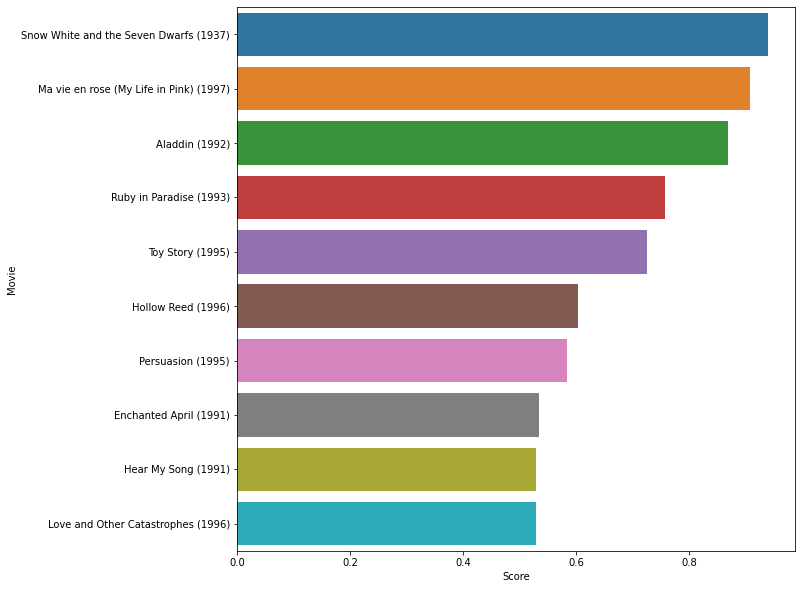

In [85]:
#plotting movie titles with highest average centiment score
import seaborn as sns
import matplotlib.pyplot as plt

top_10 = df.sort_values(by='Score', ascending=False)[:10]
plt.figure(figsize=(10,10))
sns.barplot(x='Score', y='Movie', data=top_10)

plt.show()

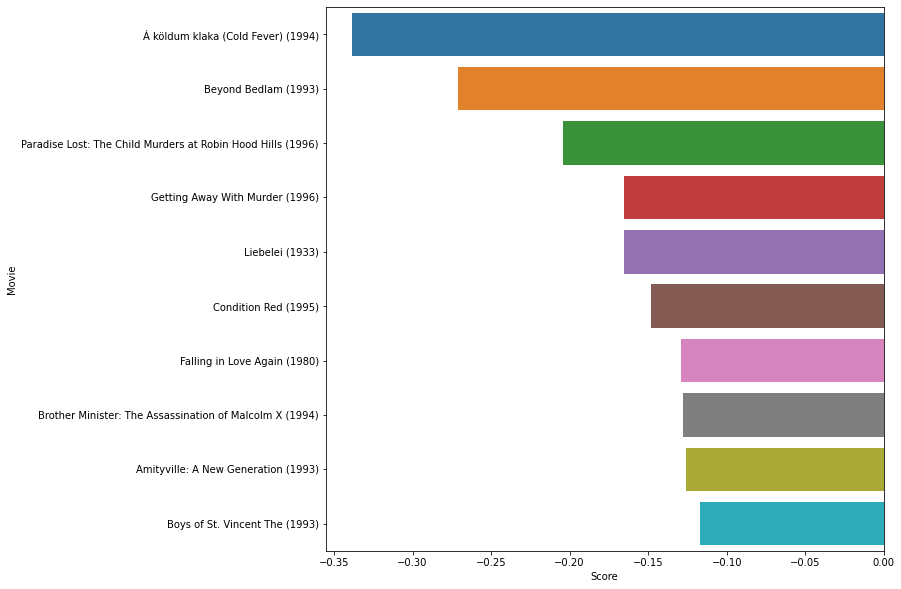

In [86]:
bottom_10 = df.sort_values(by='Score', ascending=True)[:10]
plt.figure(figsize=(10,10))
sns.barplot(x='Score', y='Movie', data=bottom_10)
plt.show()

## 3. Hybrid recommendation system

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

names = ['movieId', 'movie title', 'release_date', 'video_release_date',
         'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
         "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
         'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
        'Thriller', 'War', 'Western']
# Import u.item file to dataframe df_data
df_item = pd.read_csv('u.item', sep='|', names=names,  encoding='latin-1')

#Now we drop the unnecessary columns: release_date, video_release_date,IMDB_URl
df_item.drop(df_item.columns[[2, 3, 4]],axis=1,inplace=True)
df_item.head()

,movieId,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


We will now create a feature vectore, by taking values from "unknown" till "Sentiment_Score" 

In [94]:
df_item['Feature_Vector'] = ''
feature_vec_list = []

for i in range(len(df_item)):
    temp_vector = [df_item.iloc[i,j] for j in range(2, 22)]
    feature_vec_list.append(temp_vector)
df_item['Feature_Vector'] = feature_vec_list

# Dropping the non-useful columns
cols = [i for i in range(2, 21)]
df_item.drop(df_item.columns[cols], axis=1, inplace=True)
df_item.head()

,movieId,movie title,Sentiment_Score,Feature_Vector
0,1,Toy Story (1995),0.724900,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,GoldenEye (1995),0.144702,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,Four Rooms (1995),0.175096,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,Get Shorty (1995),0.196616,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,5,Copycat (1995),0.172799,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [95]:
# Loading ratings dataframe
df_rate = pd.read_csv('u.data', sep='\t', names=["user_id", "movieId", "rating", "timestamp"])
df_rate.head()

,user_id,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [96]:
#Merging ratings and movie genre
data = df_rate.merge(df_item, on='movieId', how='left')
data

,user_id,movieId,rating,timestamp,movie title,Sentiment_Score,Feature_Vector
0,196,242,3,881250949,Kolya (1996),0.241183,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,186,302,3,891717742,L.A. Confidential (1997),0.142673,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ..."
2,22,377,1,878887116,Heavyweights (1994),0.277610,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,244,51,2,880606923,Legends of the Fall (1994),0.259811,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
4,166,346,1,886397596,Jackie Brown (1997),0.142457,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)",0.191807,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
99996,716,204,5,879795543,Back to the Future (1985),0.201807,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
99997,276,1090,1,874795795,Sliver (1993),0.096184,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
99998,13,225,2,882399156,101 Dalmatians (1996),0.060226,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Splitting to Training and Validation

We split the dataset into training and validation based on timestamp. We do so to train on past data and test on more recent data. The idea behind this approach is to simulate a real-world scenario where the model is trained on historical data and then tested on new, unseen data.

In [97]:
#Split the dataset such that 80% is for training and 20% for testing

time_80 = np.quantile(data.timestamp.values, 0.8)
train = data[data['timestamp'] < time_80].copy()
val = data[data['timestamp'] >= time_80].copy()


train.head()

,user_id,movieId,rating,timestamp,movie title,Sentiment_Score,Feature_Vector
0,196,242,3,881250949,Kolya (1996),0.241183,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,22,377,1,878887116,Heavyweights (1994),0.277610,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,244,51,2,880606923,Legends of the Fall (1994),0.259811,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
4,166,346,1,886397596,Jackie Brown (1997),0.142457,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
5,298,474,4,884182806,Dr. Strangelove or: How I Learned to Stop Worr...,0.127487,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [98]:
val.head()

,user_id,movieId,rating,timestamp,movie title,Sentiment_Score,Feature_Vector
1,186,302,3,891717742,L.A. Confidential (1997),0.142673,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ..."
7,253,465,5,891628467,"Jungle Book, The (1994)",0.121025,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
13,210,40,3,891035994,"To Wong Foo, Thanks for Everything! Julie Newm...",0.223263,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19,234,1184,2,892079237,"Endless Summer 2, The (1994)",0.426459,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
21,167,486,4,892738452,Sabrina (1954),0.435604,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


Embedding refers to a numerical representation of items (such as movies) and users in a lower-dimensional space. These embeddings are learned through machine learning techniques, typically from user-item interaction data, and are used to capture underlying patterns and relationships between items and users. Embeddings play a crucial role in enhancing the effectiveness of recommendation systems by enabling them to understand and leverage the complex interactions between users and items.

Hybrid Recommendation not only takes the ratings given by each user to the movie item, but also average the sentiment score given to the movie item. Meaning, more the sentiment score might correspond to higher the recommendation.

## Implementing embedding with PyTorch

### Matrix Factorization using PyTorch

In [99]:
# Creating the Matrix factorization class

import torch
import torch.nn as nn
import torch.nn.functional as F

class MF(nn.Module):
    def __init__(self, num_users, num_items, num_columns, emb_size=100):
        super(MF, self).__init__()
        # setting a seed value to prevent randomness when creating the embedding vectors
        torch.manual_seed(0)
        self.user_emb = nn.Embedding(num_users+1, emb_size)  #create embedding matrix/lookup matices
        self.item_emb = nn.Embedding(num_items+1, emb_size)
        
        self.user_emb.weight.data.uniform_(0, 0.05) #initializing weights to the nn model
        self.user_emb.weight.data.uniform_(0, 0.05)
        
        # Num_colums- num of columns of the feature vectors
        self.columns = int(emb_size*2) + num_columns
        
        self.linear1 = torch.nn.Linear(self.columns, 1)
    
    def forward(self, u, v, feature_vec_list):
        u = self.user_emb(u)
        v = self.item_emb(v)
    
        user_tt = torch.Tensor(u)
        item_tt = torch.Tensor(v)
        feature_vec_tt = torch.Tensor(feature_vec_list)
        
        # Concatenating user vector, movies vector and feature vectors
        x = torch.cat((user_tt, item_tt), -1) #concating users, feature vector and items
        temp = torch.cat((x, feature_vec_tt), -1)
        
    
        output_score = F.relu(self.linear1(temp))
        
        return output_score


#### Model Training

In [100]:
# Defining a function for model training

def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        model.train()
        
        # Inputs
        users = torch.LongTensor(train.user_id.values)   
        items = torch.LongTensor(train.movieId.values)   

        ratings = torch.FloatTensor(train.rating.values)   
        ratings_shape = len(train.rating.values)
        ratings = torch.reshape(ratings, (ratings_shape, 1))

        train_movies_list = train.movieId.values
        train_feature_vec_list = [df_item['Feature_Vector'][item-1] for item in train_movies_list]
              
        # Model Prediction
        y_hat = model(users, items, train_feature_vec_list)
        
        # Model evaluation
        rmse_loss = torch.sqrt(F.mse_loss(y_hat, ratings))

        optimizer.zero_grad()
        rmse_loss.backward()
        optimizer.step()
        testloss = valid_loss(model)
        print('Train loss: %.3f | Val loss: %.3f' % (rmse_loss.item(), testloss))
    
    #to determine mean absolute error
    mae_loss = torch.nn.L1Loss()
    y_hat_input = torch.Tensor(y_hat)
    target = torch.Tensor(ratings)
    mae_value = mae_loss(y_hat_input, target)

    
    y_hat_array = torch.reshape(y_hat, (y_hat.shape[0],)).cpu().detach().numpy()
    y_hat_array = np.round(y_hat_array, 0)
    y_hat_array = np.where(y_hat_array>=6, 5, y_hat_array) 
    y_hat_array = np.where(y_hat_array==0, 1, y_hat_array)
   
    y_test = train.rating.values

    print('\nProcess finished!\n')
    return y_test, y_hat_array, rmse_loss.item(), mae_value.item()

#### Model Evaluation 

In [101]:
# Defining a function for model evaluation
def valid_loss(model):
    model.eval()
    
    # Inputs
    users = torch.LongTensor(val.user_id.values)   
    items = torch.LongTensor(val.movieId.values)   
    ratings = torch.FloatTensor(val.rating.values)     
    ratings = torch.FloatTensor(val.rating.values)   
    ratings_shape = len(val.rating.values)
    ratings = torch.reshape(ratings, (ratings_shape, 1))

    val_movies_list = val.movieId.values
    val_feature_vec_list = [df_item['Feature_Vector'][item-1] for item in val_movies_list]
     
    # Model Prediction
    y_hat = model(users, items, val_feature_vec_list)
    y_hat = torch.round(y_hat)
    
    # Model evaluation
    rmse_loss = torch.sqrt(F.mse_loss(y_hat, ratings))
    return rmse_loss.item()

#### Hyperparameter Tuning with Latent Vector Sizes 20 , 30 , 40 , 50 

1. Initial Training (30 epochs, learning rate=0.1): In the initial training stage, the model is trained for a relatively larger number of epochs (30 in this case) with a higher learning rate (0.1). This allows the model to quickly learn the basic patterns and relationships in the data. Higher learning rates can help the model converge faster, but they can also lead to overshooting optimal parameter values.

2. Further Training (20 epochs, learning rate=0.01): After the initial training, the model is further fine-tuned with a smaller learning rate (0.01) and for fewer epochs (20 in this case). The purpose of this step is to allow the model to make smaller adjustments to its parameters, refining the learned embeddings and adapting to more intricate patterns in the data. A smaller learning rate helps prevent overshooting and provides more stable convergence.

By using this two-stage training approach, you are giving the model the opportunity to first capture the major patterns in the data quickly and then focus on refining those patterns with more careful adjustments. This can often lead to better model performance compared to training with a single set of hyperparameters for all epochs.

In [102]:
# Setting initial hyperparameters to instantiate MF class

num_columns = len(df_item['Feature_Vector'][0])
num_users = len(np.sort(np.unique(data.user_id.unique())))
num_items = len(np.sort(np.unique(data.movieId.unique())))

# Defining the latent vector sizes
latent_vectors = [20, 30, 35, 40, 50]
results = []
 
for i in range(len(latent_vectors)):
    latent_vector = latent_vectors[i]
    
    print('\nRunning model with Latent vectors size of {}\n'.format(latent_vector))
    model = MF(num_users=num_users, num_items=num_items, num_columns=num_columns, emb_size=latent_vector)
    
    print('\nTraining the model with:  epochs=30 | learning rate=0.1.\n')
    y_test, y_pred, rmse_loss, mae_loss = train_epocs(model, epochs=30, lr=0.1, wd=1e-5)
    print('\nModel trained for 30 epochs\n')
    
    print('\nFurther Training the Model with:  epochs=20 | learning rate=0.01.\n')
    y_test, y_pred, rmse_loss, mae_loss = train_epocs(model, epochs=20, lr=0.01, wd=1e-5)
    print('\nModel Trained for 50 epochs')
    
    results.append([model, latent_vector, y_test, y_pred, rmse_loss, mae_loss])


Running model with Latent vectors size of 20


Training the model with:  epochs=30 | learning rate=0.1.

Train loss: 3.595 | Val loss: 3.359
Train loss: 3.083 | Val loss: 2.777
Train loss: 2.366 | Val loss: 2.300
Train loss: 1.978 | Val loss: 1.994
Train loss: 1.931 | Val loss: 1.823
Train loss: 1.559 | Val loss: 1.897
Train loss: 1.153 | Val loss: 2.148
Train loss: 1.257 | Val loss: 2.238
Train loss: 1.271 | Val loss: 2.147
Train loss: 1.110 | Val loss: 1.982
Train loss: 1.054 | Val loss: 1.856
Train loss: 1.138 | Val loss: 1.807
Train loss: 1.105 | Val loss: 1.826
Train loss: 1.015 | Val loss: 1.893
Train loss: 1.029 | Val loss: 1.929
Train loss: 1.073 | Val loss: 1.939
Train loss: 1.048 | Val loss: 1.885
Train loss: 1.001 | Val loss: 1.794
Train loss: 1.013 | Val loss: 1.761
Train loss: 1.034 | Val loss: 1.750
Train loss: 0.999 | Val loss: 1.794
Train loss: 0.958 | Val loss: 1.855
Train loss: 0.970 | Val loss: 1.863
Train loss: 0.988 | Val loss: 1.841
Train loss: 0.969 | Val loss: 

Train loss: 0.910 | Val loss: 1.923

Process finished!


Model Trained for 50 epochs

Running model with Latent vectors size of 50


Training the model with:  epochs=30 | learning rate=0.1.

Train loss: 3.520 | Val loss: 3.087
Train loss: 2.677 | Val loss: 2.383
Train loss: 2.257 | Val loss: 2.013
Train loss: 2.012 | Val loss: 1.801
Train loss: 1.281 | Val loss: 2.039
Train loss: 1.276 | Val loss: 2.230
Train loss: 1.219 | Val loss: 2.283
Train loss: 1.075 | Val loss: 2.331
Train loss: 1.184 | Val loss: 2.379
Train loss: 1.113 | Val loss: 2.420
Train loss: 1.056 | Val loss: 2.365
Train loss: 1.105 | Val loss: 2.136
Train loss: 1.065 | Val loss: 1.946
Train loss: 1.060 | Val loss: 1.861
Train loss: 1.058 | Val loss: 1.935
Train loss: 0.977 | Val loss: 2.043
Train loss: 0.985 | Val loss: 2.089
Train loss: 0.988 | Val loss: 2.025
Train loss: 0.964 | Val loss: 1.966
Train loss: 0.975 | Val loss: 1.954
Train loss: 0.935 | Val loss: 1.947
Train loss: 0.949 | Val loss: 1.908
Train loss: 0.948

#### Line diagram to show RMSE values for different vector size using pytorch embedding layer for Matrix Factorization 

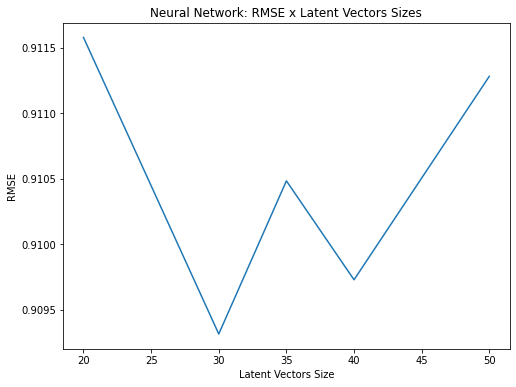

In [103]:
# Printing Line Diagram: RMSE values x Latent Vector Size
from operator import itemgetter
results = sorted(results, key=itemgetter(1), reverse=False)
latent_list = []
rmse_list = []
for i in range(len(results)):
    latent = results[i][1]
    rmse = results[i][4]
    latent_list.append(latent)
    rmse_list.append(rmse)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(latent_list,rmse_list)
plt.title('Neural Network: RMSE x Latent Vectors Sizes')
plt.xlabel('Latent Vectors Size')
plt.ylabel('RMSE')
plt.show()

In [104]:
#So we will train a model with 30 latent vector size
latent_vector = 30

print('\nRunning model with Latent vectors size of {}\n'.format(latent_vector))
model = MF(num_users=num_users, num_items=num_items, num_columns=num_columns, emb_size=latent_vector)
    
print('\nTraining the model with:  epochs=30 | learning rate=0.1.\n')
y_test, y_pred, rmse_loss, mae_loss = train_epocs(model, epochs=30, lr=0.1, wd=1e-5)
print('\nModel trained for 30 epochs\n')
    
print('\nFurther Training the Model with:  epochs=20 | learning rate=0.01.\n')
y_test, y_pred, rmse_loss, mae_loss = train_epocs(model, epochs=20, lr=0.01, wd=1e-5)
print('\nModel Trained for 50 epochs')
    


Running model with Latent vectors size of 30


Training the model with:  epochs=30 | learning rate=0.1.

Train loss: 3.542 | Val loss: 3.179
Train loss: 2.952 | Val loss: 2.575
Train loss: 2.269 | Val loss: 2.203
Train loss: 2.111 | Val loss: 1.904
Train loss: 1.830 | Val loss: 1.754
Train loss: 1.288 | Val loss: 1.904
Train loss: 1.259 | Val loss: 1.945
Train loss: 1.206 | Val loss: 1.893
Train loss: 1.072 | Val loss: 1.869
Train loss: 1.135 | Val loss: 1.880
Train loss: 1.100 | Val loss: 1.927
Train loss: 1.030 | Val loss: 1.990
Train loss: 1.074 | Val loss: 1.929
Train loss: 1.079 | Val loss: 1.858
Train loss: 1.026 | Val loss: 1.761
Train loss: 1.032 | Val loss: 1.755
Train loss: 1.047 | Val loss: 1.830
Train loss: 1.001 | Val loss: 1.912
Train loss: 0.985 | Val loss: 1.956
Train loss: 1.010 | Val loss: 1.906
Train loss: 0.989 | Val loss: 1.784
Train loss: 0.964 | Val loss: 1.687
Train loss: 0.976 | Val loss: 1.664
Train loss: 0.962 | Val loss: 1.725
Train loss: 0.941 | Val loss: 

In [105]:
# #Error rates for Latent Vector size =
# results = sorted(results, key=itemgetter(4), reverse=False)
# model = results[0][0]
# latent_vectors = results[0][1]
# y_test = results[0][2]
# y_pred = results[0][3]
# rmse_value = results[0][4]
# mae_value = results[0][5]

#### Classification Report 

In [106]:
# Printing metrics for the selected model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

def get_metrics(y_test, y_pred, rmse_value, mae_value):

    print('Micro Precision of the selected model: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall of the selected model: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score of the selected model: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('\nRMSE loss of the selected model: ', round(rmse_value, 3))
    print('\nMAE loss of the selected model: ', round(mae_value, 3))
    
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']))

get_metrics(y_test, y_pred, rmse_loss, mae_loss)

Micro Precision of the selected model: 0.43
Micro Recall of the selected model: 0.43
Micro F1-score of the selected model: 0.43


RMSE loss of the selected model:  0.909

MAE loss of the selected model:  0.716

Classification Report

              precision    recall  f1-score   support

    Rating 1       0.78      0.10      0.17      5062
    Rating 2       0.31      0.18      0.22      9101
    Rating 3       0.40      0.56      0.46     21764
    Rating 4       0.44      0.64      0.52     27507
    Rating 5       0.67      0.15      0.25     16565

    accuracy                           0.43     79999
   macro avg       0.52      0.32      0.33     79999
weighted avg       0.48      0.43      0.39     79999



#### User- Ratings-Item Factorization Matrix for predicted Ratings 

In [167]:
from tqdm import tqdm as tq

df_list = []
movies_range = len(df_item.movieId.values)
for i in tq(range(943)):
    user_id = i+1
    users_num = movies_range
    items_num = movies_range

    users_test = [user_id for i in range(users_num)]
    items_test = [i+1 for i in range(items_num)]
    test_feature_vec_list = [df_item['Feature_Vector'][item-1] for item in items_test]
    y_hat = model(torch.LongTensor(users_test), torch.LongTensor(items_test), test_feature_vec_list)
    y_hat_array = torch.reshape(y_hat, (y_hat.shape[0],)).cpu().detach().numpy()
    y_hat_array = np.round(y_hat_array, 2)
    y_hat_array = np.where(y_hat_array>=6, 5, y_hat_array) 
    y_hat_array = np.where(y_hat_array==0, 1, y_hat_array)
    
    df_temp = pd.DataFrame({user_id: y_hat_array})
    df_list.append(df_temp)
df_mf = pd.concat(df_list, 1)
df_mf = df_mf.T
df_mf.columns = df_mf.columns.values+1
df_mf = df_mf.T.reset_index()
df_mf.rename(columns={'index':'movieId'}, inplace=True)
df_mf

100%|████████████████████████████████████████████████████████████████████████████████| 943/943 [00:13<00:00, 67.48it/s]


,movieId,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
0,1,3.97,3.97,2.89,2.46,3.49,3.69,2.45,4.12,4.39,...,2.45,4.41,4.27,3.55,2.45,5.03,3.59,4.25,2.46,3.88
1,2,3.37,3.37,2.28,1.85,2.88,3.08,1.85,3.51,3.78,...,1.85,3.80,3.66,2.95,1.85,4.42,2.98,3.64,1.85,3.28
2,3,3.10,3.10,2.02,1.58,2.61,2.82,1.58,3.25,3.51,...,1.58,3.54,3.39,2.68,1.58,4.15,2.71,3.37,1.58,3.01
3,4,3.60,3.60,2.51,2.08,3.11,3.32,2.08,3.74,4.01,...,2.08,4.04,3.89,3.18,2.08,4.65,3.21,3.87,2.08,3.51
4,5,3.33,3.33,2.24,1.81,2.84,3.04,1.81,3.47,3.74,...,1.81,3.77,3.62,2.91,1.81,4.38,2.94,3.60,1.81,3.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,3.16,3.16,2.07,1.64,2.67,2.88,1.64,3.31,3.57,...,1.64,3.60,3.45,2.74,1.64,4.21,2.77,3.43,1.64,3.07
1678,1679,3.24,3.24,2.16,1.72,2.76,2.96,1.72,3.39,3.66,...,1.72,3.68,3.54,2.82,1.72,4.29,2.86,3.52,1.73,3.15
1679,1680,3.54,3.54,2.46,2.02,3.05,3.26,2.02,3.69,3.95,...,2.02,3.98,3.83,3.12,2.02,4.59,3.15,3.81,2.02,3.45
1680,1681,3.07,3.07,1.99,1.55,2.58,2.79,1.55,3.22,3.48,...,1.55,3.51,3.36,2.65,1.55,4.12,2.69,3.34,1.55,2.98


#### Top 10 Recommendations 

In [168]:
# Importing required libraries
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings('ignore')


top_recommend = 10
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
fscore_list = []

# Getting the top-10 recommendations for all users
# caluating the metrics and saving them in a data frame
for i in tq(range(1, 944)):
    user_id = i
    df_temp = df_mf.iloc[:,[0, user_id]].sort_values(by=user_id, ascending=False)
    items_list = df_temp.movieId.values[:top_recommend]
    items_pred_rat = df_temp[user_id][:top_recommend].values

    df_origin = data[data['user_id']==user_id].sort_values(by='movieId')
    all_movies_watched = df_origin.movieId.values
    
    movies_match_list = []
    rating_model_list = []
    rating_real_list = []
    y_pred = []
    y_true = []
    
    for movie in items_list:
        if movie in all_movies_watched:
            
            y_pred.append(int(1))
            y_true.append(int(1))

            rating_model = df_temp[user_id][movie-1] 
            rating_model_list.append(rating_model)
            movies_match_list.append(movie)        
            rating_real = df_origin[df_origin['movieId']==movie]
            rating_real = rating_real['rating'].values[0]  
            rating_real_list.append(rating_real)
        else:
            y_pred.append(int(1))
            y_true.append(int(0))
    
    if rating_real_list:
        # if the user watched any video recommended, then calculate MSE and MAE
        rmse_value = mse(rating_real_list, rating_model_list, squared=False)
        mae_value = mae(rating_real_list, rating_model_list)
    else:
        # if the user did not watch any video recommended, set RMSE and MAE as null values
        rmse_value = np.NaN
        mae_value = np.NaN
    
    # Calculating metrics
    precision, recall, fscore, _ = score(y_true, y_pred)
    precision = precision[1]
    recall = recall[1]
    fscore = fscore[1]
    
    rmse_list.append(rmse_value)
    mae_list.append(mae_value)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

df_eval = pd.DataFrame({'rmse':rmse_list, 'mae':mae_list, 'precision':precision_list,
                        'recall':recall_list, 'fscore':fscore_list})

100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:03<00:00, 246.16it/s]


In [169]:
# Printing metrics
print('RMSE mean: {}'.format(round(df_eval.rmse.mean(), 3)))
print('MAE mean: {}'.format(round(df_eval.mae.mean(), 3)))
print('Recall mean: {}'.format(round(df_eval.recall.mean(), 3)))
print('Precision mean: {}'.format(round(df_eval.precision.mean(), 3)))
print('F1 score mean: {}'.format(round(df_eval.fscore.mean(), 3)))

RMSE mean: 0.836
MAE mean: 0.779
Recall mean: 0.87
Precision mean: 0.254
F1 score mean: 0.363


In [170]:
# Top 10 recommendations for a specific user:
# Choose a specific user ID for whom you want to display recommendations
specific_user_id = 877  # Change this to the desired user ID

# Find the index corresponding to the specific user in the df_eval DataFrame
user_index = df_eval.index[df_eval.index + 1 == specific_user_id][0]

# Get the top 10 recommended movies for the specific user
df_temp_user = df_mf.iloc[:, [0, specific_user_id]].sort_values(by=specific_user_id, ascending=False)
items_list_user = df_temp_user.movieId.values[:10]  # Display top 10 recommendations
items_pred_rat_user = df_temp_user[specific_user_id][:10].values

# Display the top 10 recommended movies for the specific user
print(f"Top 10 Recommended Movies for User {specific_user_id}:\n")
for movie_id, rating in zip(items_list_user, items_pred_rat_user):
    movie_title = data[data['movieId'] == movie_id]['movie title'].values[0]
    rating_str = "{:.3f}".format(rating)  # Convert to string with 3 decimal places
    print(f"Movie Title: {movie_title} - Rating: {rating_str}")

# Display metrics for the specific user
print("\nMetrics for User", specific_user_id)
print("RMSE:", "{:.3f}".format(df_eval.loc[user_index, 'rmse']))
print("MAE:", "{:.3f}".format(df_eval.loc[user_index, 'mae']))
print("Precision:", "{:.3f}".format(df_eval.loc[user_index, 'precision']))
print("Recall:", "{:.3f}".format(df_eval.loc[user_index, 'recall']))
print("F1 Score:", "{:.3f}".format(df_eval.loc[user_index, 'fscore']))




Top 10 Recommended Movies for User 877:

Movie Title: Wrong Trousers, The (1993) - Rating: 4.770
Movie Title: Close Shave, A (1995) - Rating: 4.770
Movie Title: Shawshank Redemption, The (1994) - Rating: 4.680
Movie Title: Casablanca (1942) - Rating: 4.670
Movie Title: Wallace & Gromit: The Best of Aardman Animation (1996) - Rating: 4.660
Movie Title: Schindler's List (1993) - Rating: 4.650
Movie Title: Manchurian Candidate, The (1962) - Rating: 4.580
Movie Title: Rear Window (1954) - Rating: 4.570
Movie Title: Titanic (1997) - Rating: 4.560
Movie Title: Star Wars (1977) - Rating: 4.550

Metrics for User 877
RMSE: nan
MAE: nan
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


#### Top 20 Movie Recommendation

In [171]:
# Importing required libraries
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings('ignore')


top_recommend = 20
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
fscore_list = []

# Getting the top-20 recommendations for all users
# caluating the metrics and saving them in a data frame
for i in tq(range(1, 944)):
    user_id = i
    df_temp = df_mf.iloc[:,[0, user_id]].sort_values(by=user_id, ascending=False)
    items_list = df_temp.movieId.values[:top_recommend]
    items_pred_rat = df_temp[user_id][:top_recommend].values

    df_origin = data[data['user_id']==user_id].sort_values(by='movieId')
    all_movies_watched = df_origin.movieId.values
    
    movies_match_list = []
    rating_model_list = []
    rating_real_list = []
    y_pred = []
    y_true = []
    
    for movie in items_list:
        if movie in all_movies_watched:
            
            y_pred.append(int(1))
            y_true.append(int(1))

            rating_model = df_temp[user_id][movie-1] 
            rating_model_list.append(rating_model)
            movies_match_list.append(movie)        
            rating_real = df_origin[df_origin['movieId']==movie]
            rating_real = rating_real['rating'].values[0]  
            rating_real_list.append(rating_real)
        else:
            y_pred.append(int(1))
            y_true.append(int(0))
    
    if rating_real_list:
        # if the user watched any video recommended, then calculate MSE and MAE
        rmse_value = mse(rating_real_list, rating_model_list, squared=False)
        mae_value = mae(rating_real_list, rating_model_list)
    else:
        # if the user did not watch any video recommended, set RMSE and MAE as null values
        rmse_value = np.NaN
        mae_value = np.NaN
    
    # Calculating metrics
    precision, recall, fscore, _ = score(y_true, y_pred)
    precision = precision[1]
    recall = recall[1]
    fscore = fscore[1]
    
    rmse_list.append(rmse_value)
    mae_list.append(mae_value)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

df_eval = pd.DataFrame({'rmse':rmse_list, 'mae':mae_list, 'precision':precision_list,
                        'recall':recall_list, 'fscore':fscore_list})

100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:04<00:00, 195.47it/s]


In [172]:
items_list

array([169, 408, 483,  64, 114, 318, 657, 603, 313,  50,  12,  98, 474,
       134, 272, 178, 357, 480, 187, 511], dtype=int64)

In [173]:
# Printing metrics
print('RMSE mean: {}'.format(round(df_eval.rmse.mean(), 3)))
print('MAE mean: {}'.format(round(df_eval.mae.mean(), 3)))
print('Recall mean: {}'.format(round(df_eval.recall.mean(), 3)))
print('Precision mean: {}'.format(round(df_eval.precision.mean(), 3)))
print('F1 score mean: {}'.format(round(df_eval.fscore.mean(), 3)))

RMSE mean: 0.878
MAE mean: 0.793
Recall mean: 0.891
Precision mean: 0.244
F1 score mean: 0.346


In [174]:
# Top 20 recommendations for a specific user:
# Choose a specific user ID for whom you want to display recommendations
specific_user_id = 877  # Change this to the desired user ID

# Find the index corresponding to the specific user in the df_eval DataFrame
user_index = df_eval.index[df_eval.index + 1 == specific_user_id][0]

# Get the top 20 recommended movies for the specific user
df_temp_user = df_mf.iloc[:, [0, specific_user_id]].sort_values(by=specific_user_id, ascending=False)
items_list_user = df_temp_user.movieId.values[:20]  # Display top 20 recommendations
items_pred_rat_user = df_temp_user[specific_user_id][:20].values

# Display the top 20 recommended movies for the specific user
print(f"Top 20 Recommended Movies for User {specific_user_id}:\n")
for movie_id, rating in zip(items_list_user, items_pred_rat_user):
    movie_title = data[data['movieId'] == movie_id]['movie title'].values[0]
    rating_str = "{:.3f}".format(rating)  # Convert to string with 3 decimal places
    print(f"Movie Title: {movie_title} - Rating: {rating_str}")

# Display metrics for the specific user
print("\nMetrics for User", specific_user_id)
print("RMSE:", "{:.3f}".format(df_eval.loc[user_index, 'rmse']))
print("MAE:", "{:.3f}".format(df_eval.loc[user_index, 'mae']))
print("Precision:", "{:.3f}".format(df_eval.loc[user_index, 'precision']))
print("Recall:", "{:.3f}".format(df_eval.loc[user_index, 'recall']))
print("F1 Score:", "{:.3f}".format(df_eval.loc[user_index, 'fscore']))


Top 20 Recommended Movies for User 877:

Movie Title: Wrong Trousers, The (1993) - Rating: 4.770
Movie Title: Close Shave, A (1995) - Rating: 4.770
Movie Title: Shawshank Redemption, The (1994) - Rating: 4.680
Movie Title: Casablanca (1942) - Rating: 4.670
Movie Title: Wallace & Gromit: The Best of Aardman Animation (1996) - Rating: 4.660
Movie Title: Schindler's List (1993) - Rating: 4.650
Movie Title: Manchurian Candidate, The (1962) - Rating: 4.580
Movie Title: Rear Window (1954) - Rating: 4.570
Movie Title: Titanic (1997) - Rating: 4.560
Movie Title: Star Wars (1977) - Rating: 4.550
Movie Title: Usual Suspects, The (1995) - Rating: 4.540
Movie Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) - Rating: 4.530
Movie Title: Silence of the Lambs, The (1991) - Rating: 4.530
Movie Title: Citizen Kane (1941) - Rating: 4.520
Movie Title: Good Will Hunting (1997) - Rating: 4.520
Movie Title: 12 Angry Men (1957) - Rating: 4.500
Movie Title: One Flew Over the 